<!-- jupyter nbconvert --to html --no-input homework1.ipynb -->

In [50]:
import numpy as np
import torch
from torch import nn
from torch.optim import SGD
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from automatic_car.utils import train
from automatic_car.utils import test
from automatic_car.frame_dataset import FramesDataset
from automatic_car.models import Model1
from automatic_car.models import Model2
import torchmetrics
import pandas as pd
from IPython.display import display, HTML

In [51]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5


In [52]:
train_dataset = FramesDataset("train")
train_dataloader = DataLoader(train_dataset,batch_size= 32,shuffle = True)
test_dataset = FramesDataset("test")
test_dataloader = DataLoader(test_dataset,batch_size= 32,shuffle = True)

# Jose Manuel Del Valle Delgado 1848580

# Introduction

While the field of deep learning continues to advance and mature daily, there remains a lack of consensus on the definitive approach to determine an optimal model. Unfortunately, I do not have access to sufficient computational power to test various models and parameters extensively. Consequently, the analysis will primarily concentrate on the obtained results.

The scenario involves a car operating within a simulated environment. The primary goal is to address an image classification problem, aiming to understand the behavior of a racing car within a Gym environment.
Here's a video example of the environment.

![Example of a run](./media/full_frame.gif)

One notable observation while exploring the environment is its utilization of a technique known as parallax scrolling, where the car appears as a stationary image.
Another aspect worth noting is the absence of variations in brightness and frame rotations within the environment.
Consequently, employing data augmentation techniques would not yield significant utility.

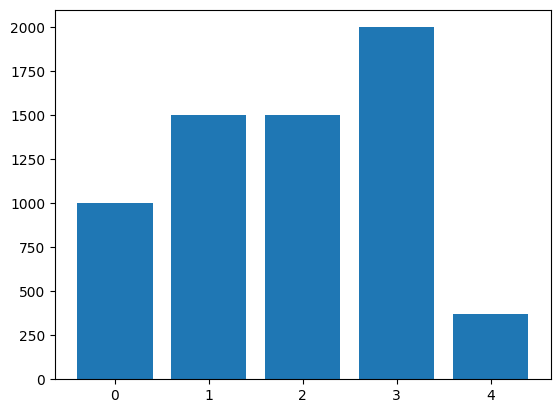

In [53]:
examples_dict = train_dataset.get_examples_per_class()
plt.bar(range(len(examples_dict)), list(examples_dict.values()), align='center')
plt.xticks(range(len(examples_dict)), list(str(k) for k in examples_dict.keys()))
plt.show()

# Models evaluation

To begin, I initiated the training of the two models across $80$ epochs, with minibatches of size 32. To evaluate the model's quality, the initial step involved assessing the loss. PyTorch offers modularity in creating and training neural networks, granting comprehensive control over both the optimizer and the loss function.

For the loss function, I opted for CrossEntropy for noth models loss due to its flexibility in assigning weights to individual classes, considering variations in the number of examples per class, in order to address the problems related to the unbalanced dataset.

Regarding the optimizer, I employed stochastic gradient descent (SGD) due to its fundamental nature and typically reliable performance on model 1, and Adam in the second model for its effectivness.
 Here are the obtained results.

In [54]:
num_channels = train_dataset.get_num_channels()
num_classes = train_dataset.get_num_classes()
model1 = Model1(num_channels=num_channels,num_classes=num_classes)

if model1.exists():
    torch.load(f= model1.path)
    
else:
    loss_fn = nn.CrossEntropyLoss(weight= train_dataset.get_weights())
    optimizer = SGD(model1.parameters(),lr = 0.001)
    train_loss = []
    test_loss = []
    for _ in range(EPOCHS):
        train_loss.append(train(model=model1,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=DEVICE))
        test_loss.append(test(model=model1,data_loader=test_dataloader,loss_fn=loss_fn,device=DEVICE))
    torch.save(obj = model1.state_dict(),f = model1.path )

    plt.plot(train_loss,label='Train loss')
    plt.plot(test_loss,label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    loss_min = np.round(np.min([train_loss,test_loss])).astype(int)
    loss_max = np.round(np.max([train_loss,test_loss])).astype(int)
    plt.xticks(np.arange(0,EPOCHS))
    plt.yticks(np.arange(0,loss_max))

    plt.legend()
    plt.savefig(model1.info("loss_graph.png"), bbox_inches='tight')
    

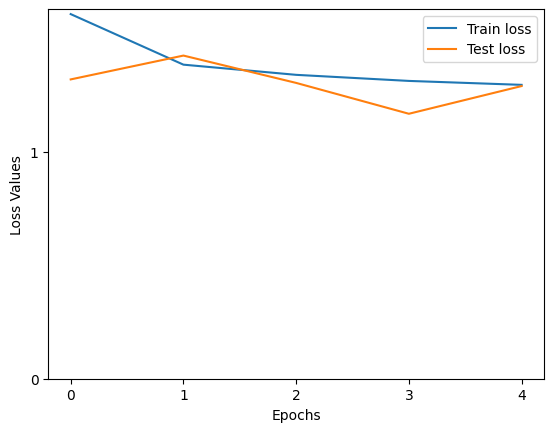

In [55]:
num_channels = train_dataset.get_num_channels()
num_classes = train_dataset.get_num_classes()
model2 = Model2(num_channels=num_channels,num_classes=num_classes)
if model2.exists():
    torch.load(f= model2.path)
else:
    loss_fn = nn.CrossEntropyLoss(weight= train_dataset.get_weights())
    optimizer = Adam(model2.parameters(),lr = 0.001)
    train_loss = []
    test_loss = []
    for _ in range(EPOCHS):
        train_loss.append(train(model=model2,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=DEVICE))
        test_loss.append(test(model=model2,data_loader=test_dataloader,loss_fn=loss_fn,device=DEVICE))
    torch.save(obj = model2.state_dict(),f = model2.path )

    plt.plot(train_loss,label='Train loss')
    plt.plot(test_loss,label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    loss_min = np.round(np.min([train_loss,test_loss])).astype(int)
    loss_max = np.round(np.max([train_loss,test_loss])).astype(int)
    plt.xticks(np.arange(0,EPOCHS))
    plt.yticks(np.arange(0,loss_max))
    plt.legend()
    plt.savefig(model2.info("loss_graph.png"), bbox_inches='tight')

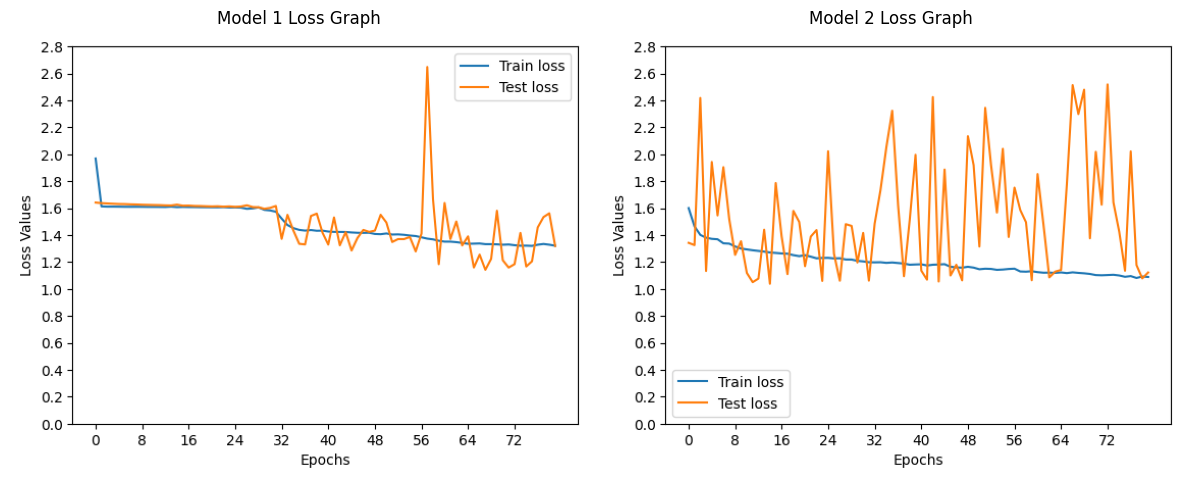

In [56]:
model_1_loss_graph = plt.imread(model1.info("loss_graph_80.png"))
model_2_loss_graph = plt.imread(model2.info("loss_graph_80.png"))


fig, axes = plt.subplots(1, 2,figsize=(12, 6))

# Display the first image on the left subplot
axes[0].imshow(model_1_loss_graph)
axes[0].set_title('Model 1 Loss Graph')  # Set title if desired

# Display the second image on the right subplot
axes[1].imshow(model_2_loss_graph)
axes[1].set_title('Model 2 Loss Graph')  # Set title if desired

# Hide axis ticks and labels
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

An important observation lies in the substantial fluctuation observed in the test loss, notably more pronounced in the second model. This aspect will be elaborated on further in subsequent sections.

While the high loss provides an indication of potential issues with the models, we will consider additional metrics to comprehensively assess the situation.

However, it's evident from the loss graphs that utilizing $80$ epochs for training might be excessive, especially considering the significant time investment. The earlier mention of hardware limitations was crucial, as training these two models for this duration took approximately 3 hours. Therefore, a strategy to mitigate this involves reducing the number of epochs and implementing a technique known as early stopping.

Preliminary analysis suggests that an optimal number of epochs might hover around $5$. Thus, the plan is to retrain the models with this reduced epoch count and assess the outcomes.

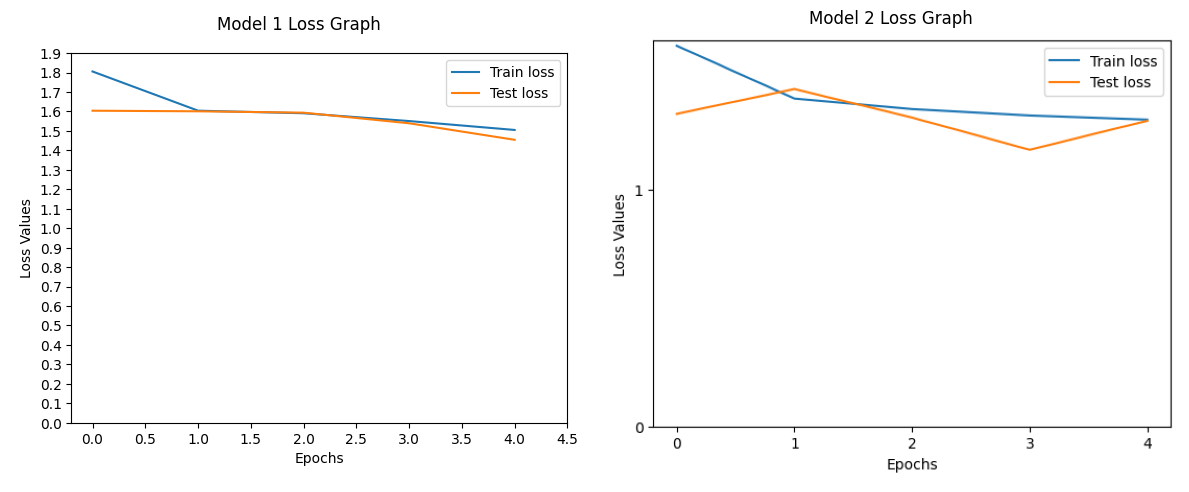

In [57]:
model_1_loss_graph = plt.imread(model1.info("loss_graph.png"))
model_2_loss_graph = plt.imread(model2.info("loss_graph.png"))


fig, axes = plt.subplots(1, 2,figsize=(12, 6))

# Display the first image on the left subplot
axes[0].imshow(model_1_loss_graph)
axes[0].set_title('Model 1 Loss Graph')  # Set title if desired

# Display the second image on the right subplot
axes[1].imshow(model_2_loss_graph)
axes[1].set_title('Model 2 Loss Graph')  # Set title if desired

# Hide axis ticks and labels
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Despite achieving stability in the training loss for model 1, it remains important to establish a quantitative measure of its performance. Initially, let's focus on obtaining a snapshot of its accuracy.

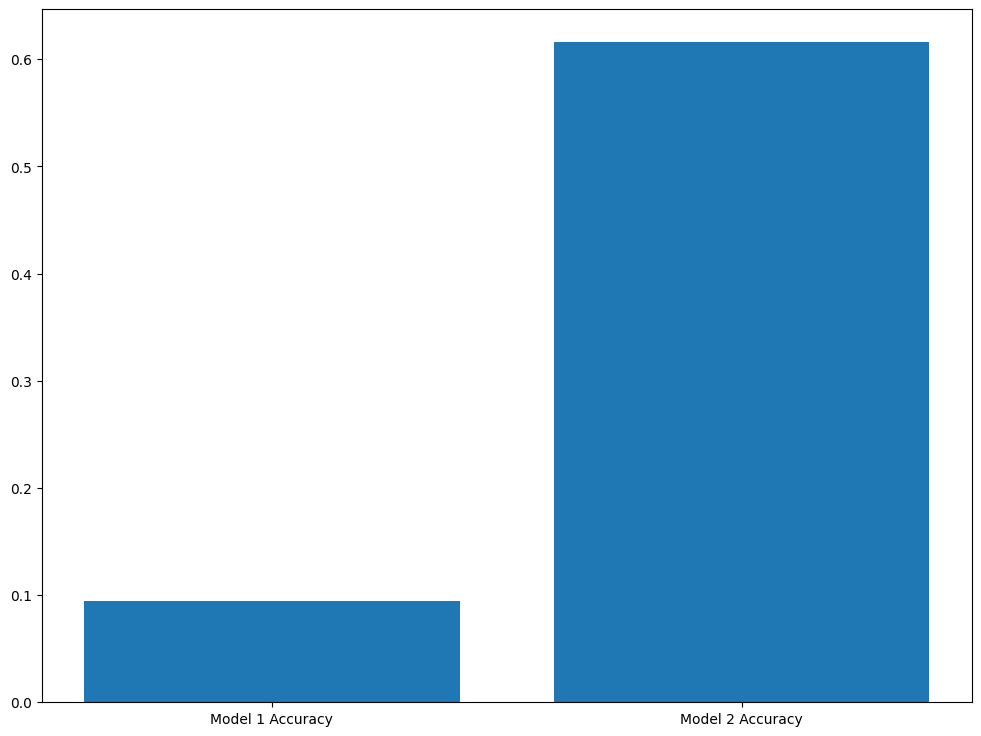

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 9))
accuracy1 = torchmetrics.Accuracy(task = "multiclass",num_classes=num_classes)
accuracy2 = torchmetrics.Accuracy(task = "multiclass",num_classes=num_classes)



model1.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model1(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        accuracy1.update(preds,y)
model2.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model2(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        accuracy2.update(preds,y)
values = [accuracy1.compute(),accuracy2.compute()]

plt.bar(["Model 1 Accuracy","Model 2 Accuracy"],values)
print()

In terms of accuracy, it appears that model 2 outperforms model 1 significantly, contrary to our expectations based on the progression of the models' losses. To understand this discrepancy, let's delve into the underlying reasons.

As highlighted in the introduction, we previously acknowledged the highly imbalanced nature of the training dataset. However, this imbalance becomes even more apparent upon closer inspection of the training data.

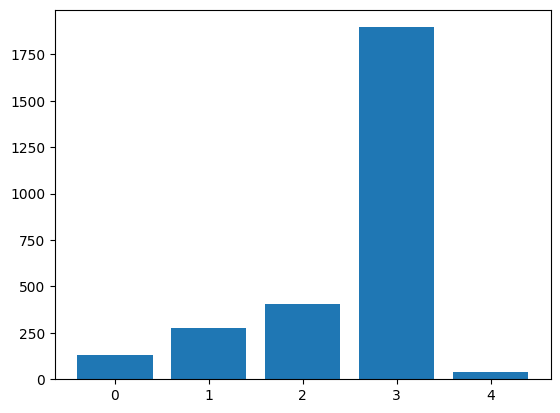

In [59]:
tests_dict = test_dataset.get_examples_per_class()
plt.bar(range(len(tests_dict)), list(tests_dict.values()), align='center')
plt.xticks(range(len(tests_dict)), list(str(k) for k in tests_dict.keys()))
plt.show()

To gain a more comprehensive understanding of the data distribution, let's analyze the percentage of elements divided by class and keep these numbers in mind.

In [60]:
n_tests = np.array(list(test_dataset.get_examples_per_class().values()))
n_tests = np.round(n_tests/n_tests.sum()*100,2)
data = {f"% of elements of Class {i}":v for i,v in enumerate(n_tests)}
df = pd.DataFrame([data])

display(HTML(df.to_html(index=False)))


% of elements of Class 0,% of elements of Class 1,% of elements of Class 2,% of elements of Class 3,% of elements of Class 4
4.84,10.0,14.77,68.97,1.42


The observation that class $3$ constitutes around $70%$ of the total dataset raises suspicions. One possible explanation for what we're observing could be as follows:

Model 1, being a basic CNN, exhibits an accuracy of approximately $20%$, which suggests that it might be making random guesses among the five available classes.

Conversely, Model 2 is more complex and deeper, implying a higher number of parameters and overall complexity. This complexity might result in overfitting, where the model essentially memorizes the training data, leading it to predominantly predict class 3 to increase accuracy. To illustrate what I'm trying to say, if we consistently predict class 3 for 100 examples, we would achieve around $70%$ accuracy, the model misclassifies only the remaining classes, which constitute a mere $30%$.

This situation highlights a well-known issue: accuracy is not a reliable metric for imbalanced datasets. The example provided serves as a demonstration of this limitation.

When handling an imbalanced dataset, precision and recall become preferred metrics. Precision represents the model's capability to avoid false positives, while recall represents its ability to avoid false negatives. An ideal model would display high values for both metrics, yet there typically exists a trade-off between precision and recall. The choice between the two depends on the specific application.

In this scenario, lacking clarity on which metric holds more significance to minimize, I have opted for another metric known as the F1 score, which combines both. Specifically, we will calculate the F1 score using macro averaging, thereby disregarding the number of support instances. This decision is rooted in the limitations of other averaging methods: the micro average aligns closely with accuracy, while the weighted average may excessively emphasize classes with a surplus of examples, such as class 3 in this case.

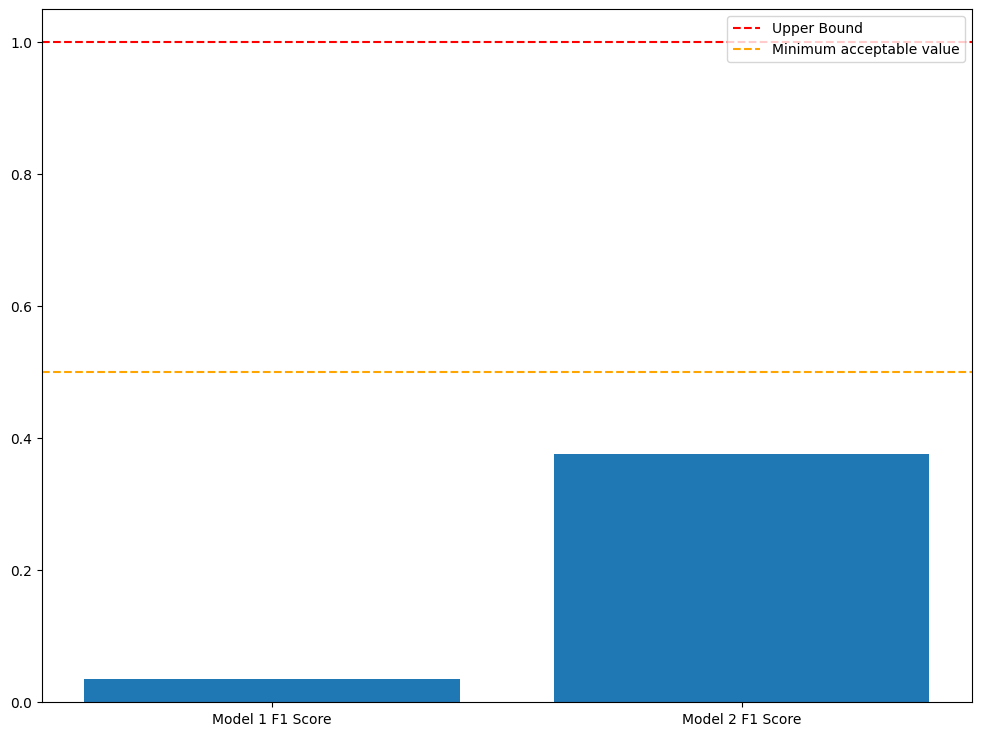

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 9))
f1score1 = torchmetrics.F1Score(task = "multiclass",num_classes=num_classes,average='macro')
f1score2 = torchmetrics.F1Score(task = "multiclass",num_classes=num_classes,average='macro')



model1.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model1(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        f1score1.update(preds,y)
model2.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model2(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        f1score2.update(preds,y)
values = [f1score1.compute(),f1score2.compute()]

ax.bar(["Model 1 F1 Score","Model 2 F1 Score"],values)
ax.axhline(y=1, color='red', linestyle='--', label='Upper Bound')
ax.axhline(y=.5, color='orange', linestyle='--', label='Minimum acceptable value')
plt.legend()
print()

As depicted in the histogram, our achieved F1 score falls significantly below an acceptable minimum threshold, let alone reaching a good standard. This aligns with our previous assertions that these models' performance is notably inadequate.

## Conclusions

But why might this be the case?

One prominent reason is the relatively small size of the dataset concerning the complexity of deep learning models. Consequently, it becomes easier for these models to escalate in complexity and overfit the data, a situation particularly noticeable in model 2.

Moreover, the visual similarity among the photos doesn't let trivial models, like model 1, to generalize well. For instance, here are three sample photos extracted from the training dataset, each representing class 0, 1, and 3.

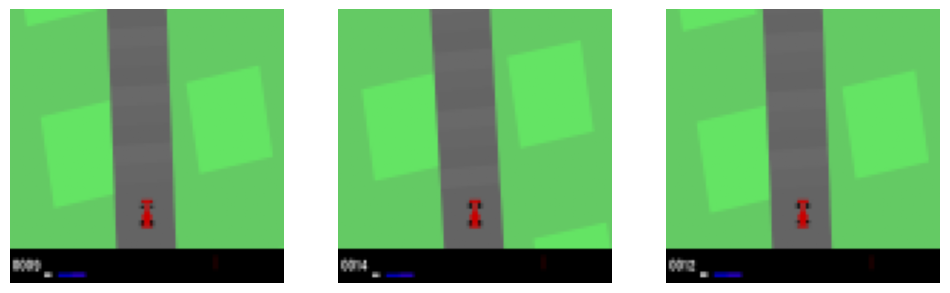

In [62]:
img1 = plt.imread("data/test/3/0040.png")
img2 = plt.imread("data/test/0/0048.png")
img3 = plt.imread("data/test/2/0003.png")
ig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12, 6))
ax[0].imshow(img1)
ax[0].axis("off")
ax[1].imshow(img2)
ax[1].axis("off")
ax[2].imshow(img3)
ax[2].axis("off")
print()

Upon examining these images ('data/test/3/0040.png', 'data/test/0/0048.png', and 'data/test/2/0003.png'), it's apparent that distinguishing among them is challenging, as I struggled to identify which image corresponds to which class. Considering these challenges, it's plausible that the models' limitations persist regardless of the extent of their training or specialization.

This leads me to believe that the dataset itself might not be suitable for the intended task. Allow me to elaborate:

In the introduction, I included a GIF illustrating the environment, if we focus on the lower part of that GIF.

![cropped_frame](media/cropped_frame.gif)

The movements of the elements in the bar is evidently linked to the state of the preceding action (even though I could not find anything in the documentation), indicating that knowledge of the optimal next action is not only reliant on the current frame but also dependent on the previous frame and its state.

To illustrate this further, the car has three levels of acceleration. Decelerating by a level reduces the acceleration, indicating that regardless of the subsequent action, braking isn't a viable choice when the vehicle is stationary. Additionally, when the car is motionless, it's impossible to steer left or right, and idling results in point deductions. Consequently, the only viable option is to accelerate.

This example clarifies two aspects. Firstly, the predominance of class 3 (gassing) instances can be attributed to the fact that often, accelerating is the only feasible action. Secondly, the information conveyed by the bar is crucial. Unfortunately, due to the small size of the images, extracting information from the lower bar becomes exceedingly challenging, given its relatively small portion of the frame.

In my spare time, I attempted to train a model to address this issue, locating where the bar is (see frame_dataset.ModifiedFramesDataset) but unfortunately, I was unsuccessful (mainly due to the fact that the images convey no information and are mostly black).

# Resources

- [What is parallax scrolling](https://en.wikipedia.org/wiki/Parallax_scrolling#:~:text=Parallax%20scrolling%20is%20a%20technique,traditional%20animation%20since%20the%201930s.)
- [Why I choose 32 minibatches](https://twitter.com/ylecun/status/989610208497360896)
- [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [Explanation on why the loss is so volatile in model2](https://forums.fast.ai/t/very-volatile-validation-loss/7573/6)
- [Another Explanation on why the loss is volatile in model2](https://stats.stackexchange.com/questions/345990/why-does-the-loss-accuracy-fluctuate-during-the-training-keras-lstm)
- [Yet another explanation on why the loss is volatile in model2](https://stats.stackexchange.com/questions/363592/what-influences-fluctuations-in-validation-accuracy)
- [How to read F1 Score](https://stephenallwright.com/interpret-f1-score/)
- [Why i choose macro averaged F1 Score](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=(3)-,Macro%20Average,-Macro%20averaging%20is)
- [Why I choose Accuracy and F1 score as metrics](https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd)
- [Why I choose F1 score over precision and recall and precision and recall tradeoff](https://medium.com/analytics-vidhya/precision-recall-tradeoff-79e892d43134)
